In [53]:
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns
import copy
import ast
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import sys
import os

sys.path.insert(0, '../../')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, recall_score, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

from library.notebook_api.data_loader import CombinedDataLoader, ModelDataLoader

alt.data_transformers.enable("vegafusion")
alt.renderers.enable('default')

RendererRegistry.enable('default')

## Load Data & Create Csv

In [54]:
full_model_data = ModelDataLoader('003')
full_model_data.df.to_csv('output2.csv', index=False)
data_df = full_model_data.df

In [55]:
# data_df = pd.read_csv(
#     '/Users/tetyananesdill/music_modeling_capstone/notebooks/exploratory/output2.csv'
# )

In [56]:
data_df

,index,track_id,dataset,audio_path,label,fma_genre_top,fma_genres,fma_genres_all,file_available,sampling_rate,...,zero_crossing_rate_mean,rms_mean,chroma_stft_mean,mfccs_mean,onset,tempo,contrast,tonnetz,mfccs_min,mfccs_max
0,0,000002,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,0.098364,0.141225,0.424169,-1.742610,1.403928,166.708664,21.300203,0.022087,-505.499176,196.868652
1,2,000005,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,...,0.059334,0.145243,0.475249,1.318397,1.384270,99.384018,21.096722,0.005648,-528.116272,209.443054
2,3,000010,fma,/project_data_source/free_music_archive/fma_sm...,pop,Pop,[10],[10],1.0,44100,...,0.080989,0.186656,0.430406,2.244156,1.123551,112.347145,20.852177,-0.033316,-537.197205,229.155151
3,15,000140,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,44100,...,0.027256,0.068459,0.450882,-3.624865,1.135973,107.666016,21.727451,0.012266,-592.895813,199.950806
4,16,000141,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,44100,...,0.034120,0.100852,0.341356,-4.471582,0.881413,120.185318,23.654802,-0.003315,-536.546936,222.208649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,49593,155315,fma,/project_data_source/free_music_archive/fma_la...,rock,Rock,[25],[25],1.0,48000,...,0.032357,0.136684,0.525699,2.354369,1.015966,100.446426,21.076494,0.026837,-481.190033,235.711487
396,49594,155316,fma,/project_data_source/free_music_archive/fma_la...,rock,Rock,[25],[25],1.0,48000,...,0.026704,0.143535,0.443451,3.344367,1.024267,89.285713,21.251328,0.056219,-281.556030,235.779968
397,49595,155317,fma,/project_data_source/free_music_archive/fma_la...,rock,Rock,[25],[25],1.0,48000,...,0.038817,0.113076,0.638051,3.844987,0.966649,117.187500,20.655001,-0.004262,-248.138168,220.233063
398,49596,155318,fma,/project_data_source/free_music_archive/fma_la...,rock,Rock,[25],[25],1.0,48000,...,0.040220,0.105109,0.588148,2.824294,1.051786,95.338982,20.832283,0.012935,-303.344910,233.896667


### Select in scope genres and check how well classes are balanced 

In [57]:
in_scope_labels = [
    'rock', 'electronic', 'hiphop', 'classical', 'jazz', 'country'
]
data_df = data_df[data_df['label'].isin(in_scope_labels)]

In [58]:
class_dis = pd.DataFrame(data_df['label'].value_counts(normalize=True) *
                         100).reset_index()

alt.Chart(class_dis).mark_bar().encode(x=alt.X('label:Q', title=None),
                                       y=alt.Y('index:N',
                                               sort='-x',
                                               title=None),
                                       color='label:Q')

alt.Chart(...)

In [59]:
genres = class_dis['index']

## Train - Test Split 

In [8]:
y = data_df['label']
x = data_df[[
    'spectral_centroids_mean', 'spectral_centroids_delta_mean',
    'spectral_centroids_accelerate_mean', 'spectral_bandwidth_mean',
    'spectral_rolloff_mean', 'zero_crossing_rate_mean', 'rms_mean',
    'chroma_stft_mean', 'mfccs_mean', 'tempo', 'onset', 'contrast', 'tonnetz',
    'mfccs_min', 'mfccs_max'
]]

X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
train_df = pd.concat([X_train, y_train], axis=1)
y_train.count()

23480

## SMOTE for class imbalance 

In [9]:
smote = SMOTE(random_state=42)

print(len(X_train))
print(len(y_train))

x_smote, y_smote = smote.fit_resample(X_train, y_train)

y_smote.value_counts()

print(len(x_smote))

23480
23480
68226


# Classificaiton 

## Original dataset with all features 

In [10]:
X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(X_train_og, y_train_og)

y_pred_og = RandomForest.predict(X_test_og)

In [11]:
print(classification_report(y_test_og, y_pred_og))

              precision    recall  f1-score   support

   classical       0.73      0.82      0.77       263
     country       0.67      0.07      0.12        59
  electronic       0.69      0.71      0.70      1830
      hiphop       0.70      0.50      0.58       726
        jazz       0.75      0.07      0.12       134
        rock       0.80      0.88      0.84      2858

    accuracy                           0.75      5870
   macro avg       0.72      0.51      0.52      5870
weighted avg       0.75      0.75      0.74      5870



In [12]:
pd.DataFrame(y_train_og.value_counts(normalize=True) * 100)

,label
rock,48.692504
electronic,31.166951
hiphop,12.376491
classical,4.484668
jazz,2.278535
country,1.000852


## Full dataset/ smote for imbalanced classes

### Random Forest

In [13]:
RandomForest = RandomForestClassifier(random_state=42)

RandomForest.fit(x_smote, y_smote)

y_pred_smote = RandomForest.predict(X_test)

In [14]:
classification_report_rf = pd.DataFrame(
    classification_report(y_test, y_pred_smote, output_dict=True)).T
classification_report_rf

,precision,recall,f1-score,support
classical,0.628571,0.839695,0.718954,262.000000
country,0.253731,0.314815,0.280992,54.000000
electronic,0.710654,0.648261,0.678025,1811.000000
hiphop,0.606803,0.655882,0.630389,680.000000
jazz,0.196262,0.293706,0.235294,143.000000
rock,0.846073,0.826370,0.836105,2920.000000
accuracy,0.734583,0.734583,0.734583,0.734583
macro avg,0.540349,0.596455,0.563293,5870.000000
weighted avg,0.745589,0.734583,0.738532,5870.000000


### Decision Tree

In [15]:
clf = DecisionTreeClassifier()

clf = clf.fit(x_smote, y_smote)

y_pred_smote_dt = clf.predict(X_test)

In [16]:
classification_report_dt = pd.DataFrame(
    classification_report(y_test, y_pred_smote_dt, output_dict=True)).T

In [17]:
dt_recall = classification_report_dt['recall']
dt_precision = classification_report_dt['precision']
dt_accuracy = round(accuracy_score(y_test, y_pred_smote_dt), 2)
dt_accuracy

0.6

### Regression

In [18]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(x_smote, y_smote)
y_pred_smote_lm = lm.predict(X_test)

In [19]:
classification_report_reg = pd.DataFrame(
    classification_report(y_test, y_pred_smote_lm, output_dict=True)).T

In [20]:
reg_recall = classification_report_reg['recall']
reg_precision = classification_report_reg['precision']
reg_accuracy = round(accuracy_score(y_test, y_pred_smote_lm), 2)
reg_accuracy

0.54

In [21]:
print(classification_report_reg)

              precision    recall  f1-score      support
classical      0.419847  0.839695  0.559796   262.000000
country        0.044521  0.481481  0.081505    54.000000
electronic     0.564732  0.279404  0.373846  1811.000000
hiphop         0.383038  0.604412  0.468910   680.000000
jazz           0.082090  0.153846  0.107056   143.000000
rock           0.790891  0.683904  0.733517  2920.000000
accuracy       0.542078  0.542078  0.542078     0.542078
macro avg      0.380853  0.507124  0.387438  5870.000000
weighted avg   0.633176  0.542078  0.562886  5870.000000


### SVM

In [22]:
svm = svm.SVC()

svm.fit(x_smote, y_smote)
y_pred_svm = svm.predict(X_test)

In [23]:
classification_report_svm = pd.DataFrame(
    classification_report(y_test, y_pred_svm, output_dict=True)).T
classification_report_svm

,precision,recall,f1-score,support
classical,0.394834,0.816794,0.532338,262.000000
country,0.043046,0.481481,0.079027,54.000000
electronic,0.667059,0.313087,0.426156,1811.000000
hiphop,0.201676,0.530882,0.292308,680.000000
jazz,0.050477,0.258741,0.084475,143.000000
rock,0.759437,0.351370,0.480450,2920.000000
accuracy,0.380068,0.380068,0.380068,0.380068
macro avg,0.352755,0.458726,0.315792,5870.000000
weighted avg,0.626189,0.380068,0.430881,5870.000000


In [24]:
svm_recall = classification_report_svm['recall']
svm_precision = classification_report_svm['precision']
svm_accuracy = round(accuracy_score(y_test, y_pred_svm), 2)
svm_accuracy

0.38

### NB

In [25]:
X_train_NB = copy.deepcopy(X_train)
X_train_NB['mfccs_min_abs'] = abs(X_train_NB['mfccs_min'])
X_train_NB['mfccs_mean_abs'] = abs(X_train_NB['mfccs_mean'])
X_train_NB['tonnetz_abs'] = abs(X_train_NB['tonnetz'])
X_train_NB['spectral_centroids_delta_mean_abs'] = abs(
    X_train_NB['spectral_centroids_delta_mean'])
X_train_NB['spectral_centroids_accelerate_mean_abs'] = abs(
    X_train_NB['spectral_centroids_accelerate_mean'])

X_train_abs = X_train_NB[[
    'spectral_centroids_mean', 'spectral_centroids_delta_mean_abs',
    'spectral_centroids_accelerate_mean_abs', 'spectral_bandwidth_mean',
    'spectral_rolloff_mean', 'zero_crossing_rate_mean', 'rms_mean',
    'chroma_stft_mean', 'mfccs_mean_abs', 'tempo', 'onset', 'contrast',
    'tonnetz_abs', 'mfccs_min_abs', 'mfccs_max'
]]

X_test_NB = copy.deepcopy(X_test)
X_test_NB['mfccs_min_abs'] = abs(X_test_NB['mfccs_min'])
X_test_NB['mfccs_mean_abs'] = abs(X_test_NB['mfccs_mean'])
X_test_NB['tonnetz_abs'] = abs(X_test_NB['tonnetz'])
X_test_NB['spectral_centroids_delta_mean_abs'] = abs(
    X_test_NB['spectral_centroids_delta_mean'])
X_test_NB['spectral_centroids_accelerate_mean_abs'] = abs(
    X_test_NB['spectral_centroids_accelerate_mean'])

X_test_abs = X_test_NB[[
    'spectral_centroids_mean', 'spectral_centroids_delta_mean_abs',
    'spectral_centroids_accelerate_mean_abs', 'spectral_bandwidth_mean',
    'spectral_rolloff_mean', 'zero_crossing_rate_mean', 'rms_mean',
    'chroma_stft_mean', 'mfccs_mean_abs', 'tempo', 'onset', 'contrast',
    'tonnetz_abs', 'mfccs_min_abs', 'mfccs_max'
]]

In [26]:
model = MultinomialNB()
model.fit(X_train_abs, (y_train))
y_pred = model.predict(X_test_abs)

nb_accuracy = round(accuracy_score(y_test, y_pred), 2)
report = classification_report(y_test, y_pred)
print(report)
print(nb_accuracy)

              precision    recall  f1-score   support

   classical       0.24      0.81      0.38       262
     country       0.06      0.17      0.08        54
  electronic       0.43      0.33      0.37      1811
      hiphop       0.20      0.35      0.25       680
        jazz       0.03      0.32      0.06       143
        rock       0.72      0.20      0.32      2920

    accuracy                           0.29      5870
   macro avg       0.28      0.36      0.24      5870
weighted avg       0.52      0.29      0.32      5870

0.29


In [27]:
classification_report_nb = pd.DataFrame(
    classification_report(y_test, y_pred, output_dict=True)).T

In [28]:
nb_recall = classification_report_nb['recall']
nb_precision = classification_report_nb['precision']

## Tune parameters for Random Forest

In [29]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=2000, num=10)]

max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

random_grid

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [30]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)
rf_random.fit(X_test, y_test)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1577,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 90,
 'bootstrap': True}

In [31]:
RandomForest_2 = RandomForestClassifier(random_state=42,
                                        n_estimators=1577,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        max_depth=50,
                                        bootstrap=True)

RandomForest_2.fit(x_smote, y_smote)

y_pred_smote = RandomForest_2.predict(X_test)

[CV] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1788; total time=  19.8s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=1577; total time=  29.4s
[CV] END bootstrap=True, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=1577; total time=  17.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=944; total time=  16.3s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1366; total time=  23.0s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1577; total time=  26.9s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=  34.6s
[CV] END bootstrap=True, max_depth=60, min_sample

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  36.6s
[CV] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=5, n_estimators=944; total time=  10.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=944; total time=  10.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1577; total time=  17.0s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  34.0s
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=522; total time=   8.5s
[CV] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1788; total time=  19.4s
[CV] END bootstrap=False, max_depth=100, min_sa

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=733; total time=  13.2s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=522; total time=   9.3s
[CV] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=1366; total time=  15.3s
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=2, n_estimators=311; total time=   5.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1366; total time=  15.6s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=311; total time=   5.1s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END bootstrap=False, max_depth=20, min_sam

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=  37.7s
[CV] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=5, n_estimators=944; total time=  10.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=944; total time=  10.8s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=311; total time=   5.3s
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=1155; total time=  20.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=311; total time=   3.2s
[CV] END bootstrap=False, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=False, max_depth=20, min_samples

In [32]:
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

   classical       0.62      0.83      0.71       262
     country       0.30      0.33      0.31        54
  electronic       0.72      0.64      0.68      1811
      hiphop       0.62      0.67      0.64       680
        jazz       0.21      0.31      0.25       143
        rock       0.84      0.83      0.84      2920

    accuracy                           0.74      5870
   macro avg       0.55      0.60      0.57      5870
weighted avg       0.75      0.74      0.74      5870



In [33]:
round(accuracy_score(y_test, y_pred_smote), 2)

0.74

In [34]:
rf_recall = classification_report_rf['recall']
rf_precision = classification_report_rf['precision']
rf_accuracy = round(accuracy_score(y_test, y_pred_smote), 2)
rf_accuracy

0.74

### Feature Importance - Random Foreset 

In [35]:
feature_importances = RandomForest.feature_importances_
feature_names = x_smote.columns

In [36]:
feature_imp_df = pd.DataFrame(feature_importances).set_index(feature_names)
feature_imp_df.reset_index(inplace=True)
feature_imp_df.columns = ['Features', 'Importance']
feature_imp_df = feature_imp_df.sort_values(by=['Importance'], ascending=False)
feature_imp_df['count cumsum'] = feature_imp_df['Importance'].cumsum()
feature_imp_df['cum_%'] = feature_imp_df['count cumsum'] / (
    feature_imp_df['Importance'].sum())

feature_imp_df

,Features,Importance,count cumsum,cum_%
10,onset,0.149240,0.149240,0.149240
8,mfccs_mean,0.085577,0.234817,0.234817
7,chroma_stft_mean,0.081309,0.316127,0.316127
13,mfccs_min,0.077737,0.393864,0.393864
6,rms_mean,0.070750,0.464613,0.464613
3,spectral_bandwidth_mean,0.068609,0.533222,0.533222
4,spectral_rolloff_mean,0.067899,0.601121,0.601121
11,contrast,0.063995,0.665116,0.665116
5,zero_crossing_rate_mean,0.063084,0.728200,0.728200
0,spectral_centroids_mean,0.057655,0.785855,0.785855


In [37]:
alt.Chart(feature_imp_df).mark_bar().encode(
    x=alt.X('Features:N', title=None, sort='-y'),
    y=alt.Y('Importance:Q', title=None),
    color=alt.Color('Importance:Q',
                    legend=None)).properties(title='Feature Importance',
                                             width=400)

base = alt.Chart(feature_imp_df).encode(
    x=alt.X('Features:N', title=None, sort='-y'))

bar_chart = base.mark_bar(color='#ADD8E6').encode(
    y=alt.Y('Importance:Q', title=None)).properties(width=600)

line = base.mark_line(strokeWidth=3, color='#cb4154').encode(
    y=alt.Y('cum_%', title=None, axis=alt.Axis(format=".0%")),
    text=alt.Text('Importance:Q'))

text = base.mark_text(strokeWidth=3,
                      color='#cb4154',
                      align='left',
                      baseline='middle',
                      dx=-10,
                      dy=-10).encode(y=alt.Y('cum_%:Q', axis=None),
                                     text=alt.Text('cum_%:Q', format="0.0%"))

(bar_chart + line + text).resolve_scale(y='independent').properties(
    title='Feature Importance - Random Forest')

alt.LayerChart(...)

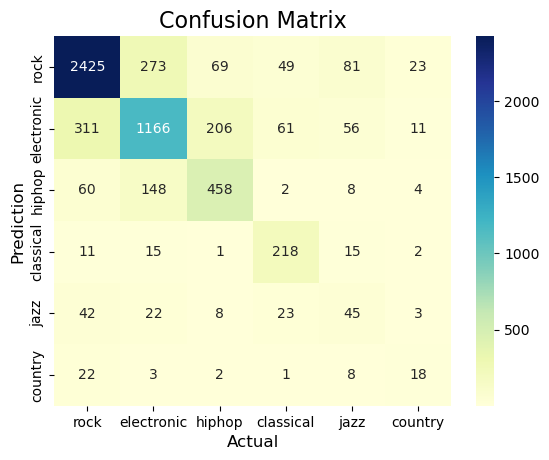

In [38]:
cm = confusion_matrix(y_test, y_pred_smote, labels=in_scope_labels)

sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='YlGnBu',
            xticklabels=in_scope_labels,
            yticklabels=in_scope_labels)
plt.ylabel('Prediction', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

## XGBoost Parameter Tunning 

In [39]:
#Encode labels into numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Convert genres to numeric values

# Check the label encoding
print(f"Encoded Labels: {le.classes_}")

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y_encoded,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

#Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# XGBoost parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

#Perform Grid Search on XGBoost
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb_model,
                               param_grid=xgb_param_grid,
                               cv=3,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=1)
xgb_grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best XGBoost model and parameters
best_xgb = xgb_grid_search.best_estimator_
print("Best XGBoost Parameters:", xgb_grid_search.best_params_)

# XGBoost evaluation
y_pred_xgb = best_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("\nBest XGBoost Accuracy:", accuracy_xgb)
print("Classification Report for XGBoost:\n",
      classification_report(y_test, y_pred_xgb, target_names=le.classes_))

Encoded Labels: ['classical' 'country' 'electronic' 'hiphop' 'jazz' 'rock']
Training set size: (23480, 15)
Test set size: (5870, 15)
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best XGBoost Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.6}

Best XGBoost Accuracy: 0.7575809199318569
Classification Report for XGBoost:
               precision    recall  f1-score   support

   classical       0.72      0.79      0.75       262
     country       0.42      0.31      0.36        54
  electronic       0.72      0.68      0.70      1811
      hiphop       0.62      0.68      0.65       680
        jazz       0.34      0.25      0.29       143
        rock       0.83      0.85      0.84      2920

    accuracy                           0.76      5870
   macro avg       0.61      0.59      0.60      5870
weighted avg       0.75      0.76      0.76      5870



In [40]:
classification_report_gb = pd.DataFrame(
    classification_report(y_test,
                          y_pred_xgb,
                          target_names=le.classes_,
                          output_dict=True)).T

gb_precision = classification_report_gb['precision']
gb_recall = classification_report_gb['recall']
gb_accuracy = round(accuracy_score(y_test, y_pred_xgb), 2)
gb_accuracy

0.76

In [41]:
probab_df = pd.DataFrame(best_xgb.predict_proba(X_test))
probab_df.columns = in_scope_labels

In [42]:
# predicted probabilities; y_true and y_predicted
X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(
    data_df['audio_path'], data_df['label'], test_size=0.2, random_state=42)

probab_df['y_pred'] = le.inverse_transform(y_pred_xgb)
probab_df['y_true'] = le.inverse_transform(y_test)

X_test_audio_df = pd.DataFrame(X_test_audio)
X_test_audio_df.reset_index(inplace=True)
probab_df_audio_path = pd.concat([probab_df, X_test_audio_df], axis=1)

In [43]:
probab_df_audio_path
probab_df_audio_path.to_csv('predicted_prob.csv', index=False)

### Confusion Matrix 

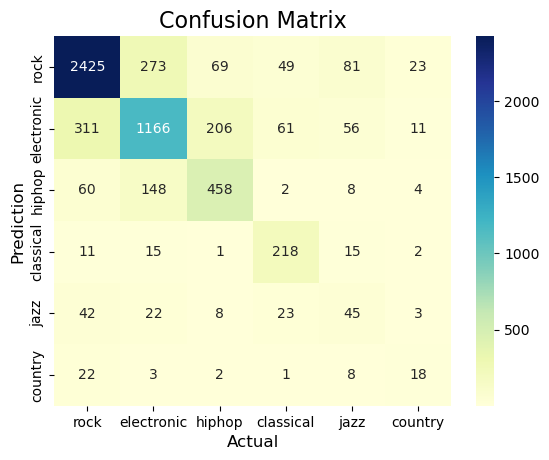

In [44]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='YlGnBu',
            xticklabels=in_scope_labels,
            yticklabels=in_scope_labels)
plt.ylabel('Prediction', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

## Ensemble Model (XGBoost and RF) 

In [45]:
#Define models with the best parameters
best_rf = RandomForestClassifier(random_state=42,
                                 n_estimators=1577,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 max_depth=50,
                                 bootstrap=True)

best_xgb = XGBClassifier(n_estimators=300,
                         max_depth=7,
                         learning_rate=0.2,
                         subsample=0.8,
                         eval_metric='mlogloss',
                         random_state=42)

# Create the weighted soft voting ensemble
ensemble_model_weighted = VotingClassifier(
    estimators=[
        ('rf', best_rf),  # Random Forest
        ('xgb', best_xgb)  # XGBoost
    ],
    voting='soft',
    weights=[2, 3]  # Favor XGBoost due to higher performance
)

# Train the ensemble model
ensemble_model_weighted.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test data
y_pred_weighted = ensemble_model_weighted.predict(X_test)

#Evaluate the model's performance
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
classification_report_weighted = classification_report(
    y_test, y_pred_weighted, target_names=le.classes_)

# Output the results
print("Accuracy with Optimized Soft Voting Ensemble (RF + XGBoost):",
      accuracy_weighted)
print("Classification Report:\n", classification_report_weighted)

Accuracy with Optimized Soft Voting Ensemble (RF + XGBoost): 0.7575809199318569
Classification Report:
               precision    recall  f1-score   support

   classical       0.71      0.81      0.75       262
     country       0.34      0.28      0.31        54
  electronic       0.72      0.68      0.70      1811
      hiphop       0.62      0.66      0.64       680
        jazz       0.33      0.29      0.31       143
        rock       0.84      0.85      0.85      2920

    accuracy                           0.76      5870
   macro avg       0.59      0.60      0.59      5870
weighted avg       0.76      0.76      0.76      5870



In [46]:
classification_report_ens = pd.DataFrame(
    classification_report(y_test,
                          y_pred_weighted,
                          target_names=le.classes_,
                          output_dict=True)).T

ens_precision = classification_report_ens['precision']
ens_recall = classification_report_ens['recall']
ens_accuracy = round(accuracy_score(y_test, y_pred_weighted), 2)

## Summary Recall Chart 

In [47]:
summary_recall = pd.concat([
    rf_recall, dt_recall, gb_recall, svm_recall, nb_recall, reg_recall,
    ens_recall
],
                           axis=1)
model_names = [
    'Random Forest', 'Decision Tree', 'XGBoost', 'SVM',
    'Multinomial NaiveBayes', 'Logistic Regression', 'Ensamble XGB + RF'
]

summary_recall.columns = model_names

summary_recall = summary_recall.T
summary_recall.reset_index(inplace=True)
summary_recall

,index,classical,country,electronic,hiphop,jazz,rock,accuracy,macro avg,weighted avg
0,Random Forest,0.839695,0.314815,0.648261,0.655882,0.293706,0.826370,0.734583,0.596455,0.734583
1,Decision Tree,0.698473,0.259259,0.524020,0.552941,0.293706,0.663356,0.596422,0.498626,0.596422
2,XGBoost,0.790076,0.314815,0.683600,0.675000,0.251748,0.852740,0.757581,0.594663,0.757581
3,SVM,0.816794,0.481481,0.313087,0.530882,0.258741,0.351370,0.380068,0.458726,0.380068
4,Multinomial NaiveBayes,0.809160,0.166667,0.331861,0.350000,0.321678,0.202740,0.289267,0.363684,0.289267
5,Logistic Regression,0.839695,0.481481,0.279404,0.604412,0.153846,0.683904,0.542078,0.507124,0.542078
6,Ensamble XGB + RF,0.805344,0.277778,0.682496,0.664706,0.286713,0.853425,0.757581,0.595077,0.757581


In [48]:
alt.Chart(summary_recall).mark_bar().encode(
    x=alt.X('amount:Q', title=None),
    y=alt.Y('type:N', title=None),
    color=alt.Color('amount:Q', legend=None),
    column=alt.Column('index',
                      title=None)).transform_fold(as_=['type', 'amount'],
                                                  fold=genres).properties(
                                                      width=100,
                                                      title='Recall by Model')

alt.Chart(...)

## Summary Precision Chart 

In [49]:
summary_precision = pd.concat([
    rf_precision, dt_precision, gb_precision, svm_precision, nb_precision,
    reg_precision, ens_precision
],
                              axis=1)

model_names = [
    'Random Forest', 'Decision Tree', 'XGBoost', 'SVM',
    'Multinomial NaiveBayes', 'Logistic Regression', 'Ensamble XGB + RF'
]

summary_precision.columns = model_names

summary_precision = summary_precision.T
summary_precision.reset_index(inplace=True)
summary_precision

,index,classical,country,electronic,hiphop,jazz,rock,accuracy,macro avg,weighted avg
0,Random Forest,0.628571,0.253731,0.710654,0.606803,0.196262,0.846073,0.734583,0.540349,0.745589
1,Decision Tree,0.538235,0.069307,0.572031,0.424859,0.112000,0.804068,0.596422,0.420083,0.653068
2,XGBoost,0.718750,0.425000,0.721445,0.623641,0.336449,0.834730,0.757581,0.610003,0.754242
3,SVM,0.394834,0.043046,0.667059,0.201676,0.050477,0.759437,0.380068,0.352755,0.626189
4,Multinomial NaiveBayes,0.244804,0.055901,0.428368,0.197183,0.032717,0.715840,0.289267,0.279135,0.523330
5,Logistic Regression,0.419847,0.044521,0.564732,0.383038,0.082090,0.790891,0.542078,0.380853,0.633176
6,Ensamble XGB + RF,0.705686,0.340909,0.719023,0.622590,0.333333,0.842176,0.757581,0.593953,0.755644


In [50]:
alt.Chart(summary_precision).mark_bar().encode(
    x=alt.X('amount:Q', title=None),
    y=alt.Y('type:N', title=None),
    color=alt.Color('amount:Q', legend=None, scale=alt.Scale(scheme='greens')),
    column=alt.Column('index', title=None)).transform_fold(
        as_=['type',
             'amount'], fold=genres).properties(width=100,
                                                title='Precision by Model')

alt.Chart(...)

## Summary Accuracy Scores 

In [51]:
accuracy_scores = [
    rf_accuracy, dt_accuracy, gb_accuracy, svm_accuracy, nb_accuracy,
    reg_accuracy, ens_accuracy
]
model_names = [
    'Random Forest', 'Decision Tree', 'XGBoost', 'SVM',
    'Multinomial NaiveBayes', 'Logistic Regression', 'Ensamble XGB + RF'
]

accuracy_scores_summary = pd.DataFrame({
    'accuracy_scores': accuracy_scores,
    'model_names': model_names
})

accuracy_scores_summary

,accuracy_scores,model_names
0,0.74,Random Forest
1,0.60,Decision Tree
2,0.76,XGBoost
3,0.38,SVM
4,0.29,Multinomial NaiveBayes
5,0.54,Logistic Regression
6,0.76,Ensamble XGB + RF


In [52]:
base = alt.Chart(accuracy_scores_summary).encode(
    y=alt.Y('model_names:N', title=None, sort='-x'),
    x=alt.X('accuracy_scores:Q', title=None, axis=None),
    color=alt.Color('accuracy_scores:Q',
                    legend=None,
                    scale=alt.Scale(scheme='oranges')),
    text=alt.Text('accuracy_scores:Q')).properties(
        width=400, height=200, title='Highest Accuracy Score by Model')

(base.mark_bar(size=20) + base.mark_text(align='left', dx=1)).configure_view(
    strokeWidth=0).configure_axis(grid=False, domain=False)

alt.LayerChart(...)